# 3. Create a digit embedding space
The third task is to use the trained network as an embedding space for images of written symbols. In this case, you'll use it to differentiate images of the greek letters alpha, beta, and gamma. Make new code files from the prior tasks. Read in your trained network as the first step and make a submodel that includes everything but the output layer..

embedding space just means everything up until the classification layer?


In [1]:
# to move files
import os
import shutil
from os import walk
from os.path import exists

from pathlib import Path

# import previous notebook
import nbimporter
import Task1AE as Note1AE
import Task1FG as Note1FG

# to save to csv
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

from enum import Enum


In [2]:
# global variables
class Alphabet(Enum):
    ALPHA = 0
    BETA= 1
    GAMMA = 2

batch_size = 32
transform = transforms.Compose(
            [ 
                Note1FG.NegativeMaxContrast(),
                transforms.Grayscale(),
                transforms.Resize(28),
                transforms.ToTensor(),
                # normalize with mean and std
                transforms.Normalize((0.1307,), (0.3801,)),
            ])

In [3]:
# Check that folders are set correctly, and there are no ipynb files
from os import walk
for (dirpath, dirnames, filenames) in walk("images/greek"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

Directory path:  images/greek
Folder name:  ['beta', 'gamma', 'alpha']
Directory path:  images/greek/beta
Folder name:  []
Directory path:  images/greek/gamma
Folder name:  []
Directory path:  images/greek/alpha
Folder name:  []


In [4]:
# Check that folders are set correctly, and there are no ipynb files
from os import walk
for (dirpath, dirnames, filenames) in walk("images/own_greek"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

Directory path:  images/own_greek
Folder name:  ['beta', 'gamma', 'alpha']
Directory path:  images/own_greek/beta
Folder name:  []
Directory path:  images/own_greek/gamma
Folder name:  []
Directory path:  images/own_greek/alpha
Folder name:  []


## A. Create a greek symbol data set
Write a program to read in the images, scale them down to 28x28, convert them to greyscale, invert the intensities


In [5]:
# create Greek dataset class
class GreekLetterDataset:
    def __init__(self, data_csv, target_csv, transform=None):

        # get numpy array from csv
        data = pd.read_csv(data_csv).to_numpy()
        targets = pd.read_csv(target_csv).to_numpy().flatten(order="F")
        
        self.data = torch.from_numpy(data)
        self.targets = torch.from_numpy(targets)
        self.transform = transform
        self.n_samples = data.shape[0]
        
    def __len__(self):
        return self.n_samples
    
    # to support the indexing such that dataset[i]
    # can be used to get ith sample.
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [6]:
def move_filenames_to_category_folder(dataset_name):
    """
    a function that creates category folders inside the dataset folder
    based on the filename. Then move the filenames to the correct folder  
    """
    # images/greek/
    target_path = "images/" + dataset_name + "/"
    
    # 1. get all filenames in the folder
    all_filenames = []
    for (dirpath, dirnames, filenames) in walk(target_path):
        if(dirpath == target_path):
            # get unique filenames
            all_filenames = filenames

    # 2. grab all the letters
    alphabet = []
    for filename in all_filenames:
        letter = filename.split("_")[0]
        alphabet.append(letter)

    # 3. remove duplicates
    alphabet = list(set(alphabet))
    
    # 4. create unique folder
    for letter in alphabet:
        try:
            # create folder
            os.mkdir(target_path + letter)
        except OSError as error: 
            print(error)  
        
    # 5. loop through each files again
    for filename in os.listdir(target_path):
        letter_bit = filename.split("_")[0]
        
        if (letter_bit in alphabet and len(filename.split("_")) > 1):
            old_path = target_path + filename
            new_path = target_path + letter_bit + "/" + filename 
            # move this file to the correct category folder
            shutil.move(old_path, new_path)

            
def check_valid(path):
    path = Path(path)
    return not path.stem.startswith('.')


def upload_to_ImageFolder(dataset_name, batch_size, transform, check_valid):
    """ A function that takes in a dataset name from local "images/"
        directory and batch size then: 
        - performs transformation to the dataset
        - upload the images to PyTorch's ImageFolder
        - returns a dataLoader object 
    """

    # - create the dataset from our images folder to datasets
    dataset = datasets.ImageFolder("images/" + dataset_name,
                                   transform=transform,
                                   is_valid_file=check_valid)

    # - get dataloader for our images
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=30)
    return dataloader

In [7]:
def save_data_as_csv(dataloader, dataset_name, is_overwrite):
    
    """
    A function that:
    - extract the data and target from dataloader
    - save them both as two separate csv files. 
    - if is_overwrite is false, it will not write anything if data already exists
    """
    
    data_filename = dataset_name + '.csv'
    target_filename = dataset_name + '_target.csv'
    
    if(is_overwrite):
        is_write = True
    else:
        # not overwrite means if file already exists dont write
        is_write = not(os.path.exists(data_filename))
    

    if(is_write):
        # 1. load the data
        data, target = next(iter(dataloader))
        csv_np = np.array([])


        # 2. create empty csv file with the headers
        header_list = list(map(str, range(0, 784)))
        header_str = ','.join(header_list)
        with open(data_filename, 'w') as csvfile:
            np.savetxt(csvfile, [], header=header_str,
                    delimiter=',', fmt='%s', comments='')

        with open(target_filename, 'w') as csvtargetfile:
            np.savetxt(csvtargetfile, [], header="category",
                    delimiter=',', fmt='%s', comments='')

        # 3. loop through each image and append to csv
        print(len(data))
        for i in range(len(data)):
            print("\nindex:>>>>", i)
            # - display the image info
            img_mat = data[i][0]
            ground_truth = target[i].numpy()
            print("ground truth:", Alphabet(ground_truth))
            plt.imshow(img_mat, cmap="gray", interpolation="none")
            plt.show()

            # - create a new csv row
            csv_row_np = np.array([])

            # - for each row in a single image
            for img_row in img_mat:

                # - append it as a single row
                img_row_np = img_row.numpy()
                csv_row_np = np.append(csv_row_np, [img_row_np])

            # - append this image row and target in csv file
            with open(data_filename, 'a') as csvfile:
                np.savetxt(csvfile, [csv_row_np], delimiter=',', fmt='%s', comments='')

            with open(target_filename, 'a') as csvtargetfile:
                np.savetxt(csvtargetfile, [ground_truth],
                        delimiter=',', fmt='%s', comments='')



In [8]:
def get_greek_dataloader_from_csv(data_csv, target_csv):
    """
    A function that:
    - extract dataset from csv file
    - create a dataloader of the dataset and return it
    """
    # 1. create dataset from csv file
    greek_dataset = GreekLetterDataset(data_csv, target_csv)

    # # 2. get data from dataset
    csv_dataloader = torch.utils.data.DataLoader(greek_dataset,
                                                 batch_size=30)
    
    return csv_dataloader
    

In [9]:
def create_Dataset_CSV(dataset_name):
    """
    A wrapper function that:
    - creates Dataset from images folder
    - save it to ImageFolder and save it as csv file
    - reload it from csv file and return the dataloader
    """
    # 1. move files to folder based on category
    move_filenames_to_category_folder(dataset_name)

    # 2. upload files to Pytorch ImageFolder
    own_dataloader = upload_to_ImageFolder(dataset_name, batch_size, transform, check_valid)

    # 3. save the data as csv
    save_data_as_csv(own_dataloader, dataset_name, is_overwrite=True)

    # 4. reload data from csv 
    csv_dataloader = get_greek_dataloader_from_csv( dataset_name+ ".csv",
                                       dataset_name + "_target.csv")
    return csv_dataloader

27

index:>>>> 0
ground truth: Alphabet.ALPHA


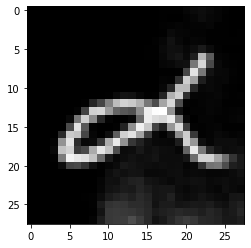


index:>>>> 1
ground truth: Alphabet.ALPHA


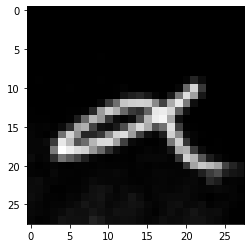


index:>>>> 2
ground truth: Alphabet.ALPHA


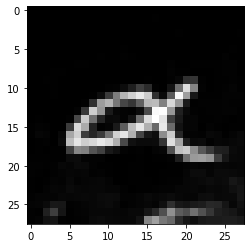


index:>>>> 3
ground truth: Alphabet.ALPHA


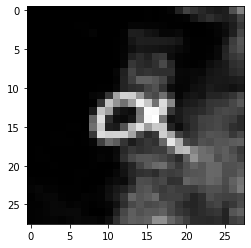


index:>>>> 4
ground truth: Alphabet.ALPHA


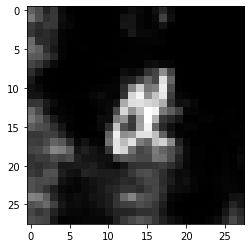


index:>>>> 5
ground truth: Alphabet.ALPHA


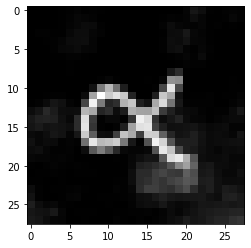


index:>>>> 6
ground truth: Alphabet.ALPHA


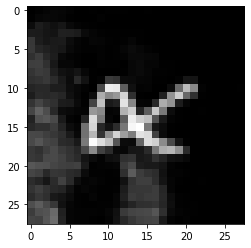


index:>>>> 7
ground truth: Alphabet.ALPHA


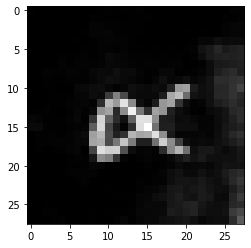


index:>>>> 8
ground truth: Alphabet.ALPHA


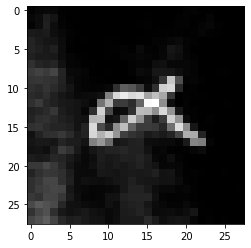


index:>>>> 9
ground truth: Alphabet.BETA


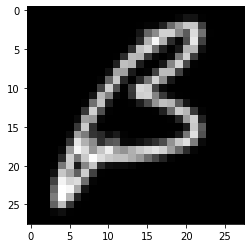


index:>>>> 10
ground truth: Alphabet.BETA


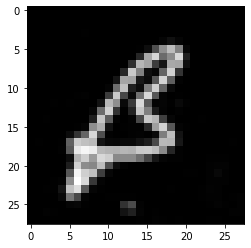


index:>>>> 11
ground truth: Alphabet.BETA


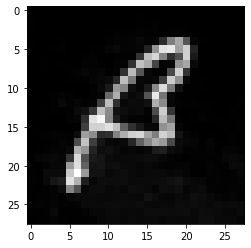


index:>>>> 12
ground truth: Alphabet.BETA


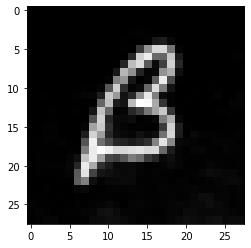


index:>>>> 13
ground truth: Alphabet.BETA


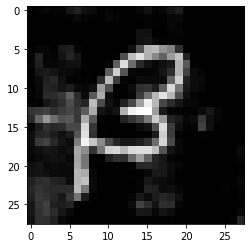


index:>>>> 14
ground truth: Alphabet.BETA


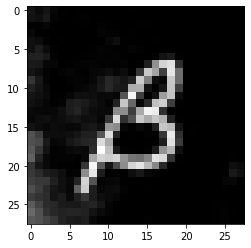


index:>>>> 15
ground truth: Alphabet.BETA


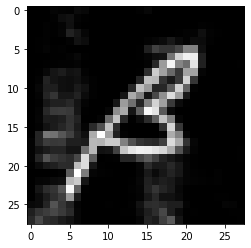


index:>>>> 16
ground truth: Alphabet.BETA


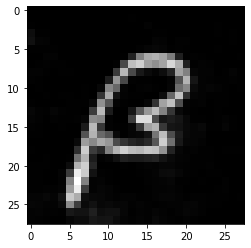


index:>>>> 17
ground truth: Alphabet.BETA


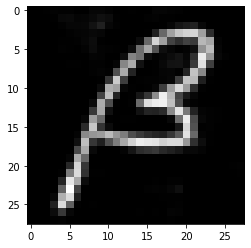


index:>>>> 18
ground truth: Alphabet.GAMMA


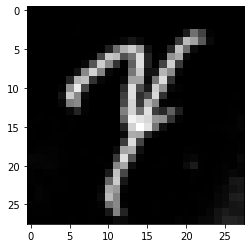


index:>>>> 19
ground truth: Alphabet.GAMMA


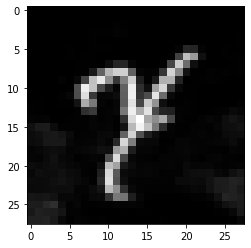


index:>>>> 20
ground truth: Alphabet.GAMMA


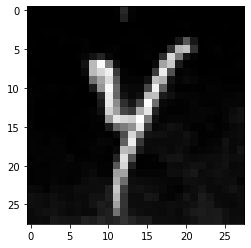


index:>>>> 21
ground truth: Alphabet.GAMMA


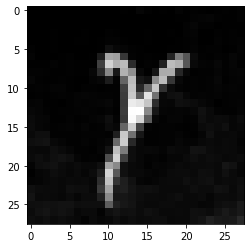


index:>>>> 22
ground truth: Alphabet.GAMMA


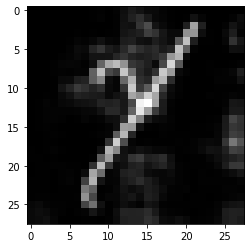


index:>>>> 23
ground truth: Alphabet.GAMMA


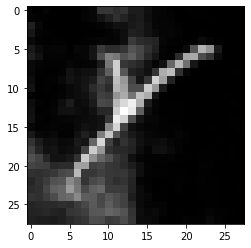


index:>>>> 24
ground truth: Alphabet.GAMMA


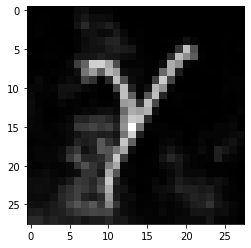


index:>>>> 25
ground truth: Alphabet.GAMMA


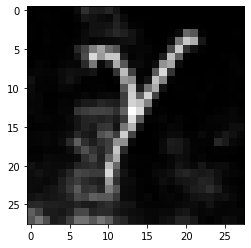


index:>>>> 26
ground truth: Alphabet.GAMMA


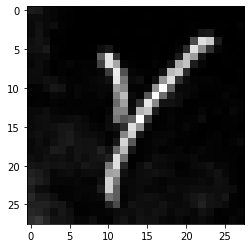

In [10]:
dataset_name = "greek"
dataloader = create_Dataset_CSV(dataset_name)

## B. Create Truncated Model

Read in the trained model and build a new model from the old network that terminates at the Dense layer with 50 outputs. Show that if you apply the network to the first training input image that it gives 50 numbers as its output.

In [11]:
# 1. Create a Submodel object 
class SubmodelDense1(Note1AE.NeuralNetwork):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward( self, x ):
        # 1. first conv, max pool, relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # 2. 2nd conv, droptout layer, max pool, relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # 3. reshape tensor.
        x = x.view(-1, 320)
        
        # 4. fully connected, relu
        x = F.relu(self.fc1(x))

        return x

In [12]:
def create_truncated_model_and_run_one_image(dataloader):
    """
    Create truncated model and run it on first image from the dataloader
    """
    
    # 1. init network
    subnetwork = SubmodelDense1()
    subnetwork.double()
    Note1FG.load_network_state(subnetwork)
    
    # 2. grab a single image
    img = Note1FG.load_firstN_data(dataloader, 1)[0]
    
    # 3. run
    reshaped_data = torch.reshape(img, (1, 1, 28, 28))
    outputSub = Note1FG.run_network(subnetwork, reshaped_data)
    print(outputSub.shape)
    
    return subnetwork

In [13]:
subnetwork = create_truncated_model_and_run_one_image(dataloader)

torch.Size([1, 50])


## C. Project the greek symbols into the embedding space 

Apply the truncated network to the greek symbols (read from the CSV file) to get a set of 27 50 element vectors.

In [14]:

csv_dataloader = get_greek_dataloader_from_csv("greek.csv",
                                       "greek_target.csv")

# run the subnetwork through the data from csv file
with torch.no_grad():
    data_from_csv, target = next(iter(csv_dataloader))
    # subnetwork.double() 
    subnetwork.eval()
    reshaped_data = torch.reshape(data_from_csv, (27, 1, 28, 28))
    output = subnetwork(reshaped_data)
    
print(output.shape)
print(output[0])

torch.Size([27, 50])
tensor([0.0000, 0.0000, 2.2976, 0.0000, 0.0000, 0.4250, 1.4210, 0.0264, 0.0000,
        1.4767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8383, 0.0000, 2.5231,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7966, 0.8418, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2869, 2.0713, 0.0000, 0.6339, 0.0000, 0.6825, 0.4438,
        4.9952, 5.4029, 0.0000, 0.0000, 0.0000, 0.0000, 0.4549, 1.7567, 4.9659,
        0.0000, 0.0000, 1.3716, 0.4214, 0.0000], dtype=torch.float64)


## D. Compute distances in the embedding space (1 for each letter)

Select one example from each set of nine (i.e. one alpha, one beta, and one gamma). Compute the sum-squared distance in the 50 dimensional embedding space between each example and all 27 examples. Note that the SSD with itself should be 0. For each example show all 27 SSD values. What pattern do you find? How well would a nearest neighbor or K-NN classifier in the embedding space do for this task?


>> alpha is more similar to gamma than it is to beta


In [15]:
def compute_ssd(vec1, vec2):
    """
        A function that computes SSD between two vectors of PyTorch tensor object
    """
    error = 0;
    for i in range(len(vec1)):
        val1 = vec1[i].item()
        val2 = vec2[i].item()
        error += (val1 - val2) * (val1 - val2)
    return error


def compute_ssd_all_data(sample_alphabet, data, letter_name):
    """
        A function that computes SSD between 
        the vector of a sample alphabet to all of the other vector in a data
    """
    print("\n>>>>>>>>> SSD for " +  letter_name +" sample:")
    i = 0;
    for other_letter in data:
        ssd = compute_ssd(sample_alphabet, other_letter)
        if(i == 0):
            print("> alpha:")
        elif(i == 9):
            print("> beta:")
        elif(i == 18):
            print("> gamma:")
        print(ssd)
        i+=1

In [16]:
# 1. get 1 sample of each letter
sample_alpha = data_from_csv[0]
sample_beta = data_from_csv[9]
sample_gamma = data_from_csv[18]

# 2. compute ssd of the 3 samples above to each of the 27 other samples
compute_ssd_all_data(sample_alpha, data_from_csv, "alpha")
compute_ssd_all_data(sample_beta, data_from_csv, "beta")
compute_ssd_all_data(sample_gamma, data_from_csv, "gamma")

print(sample_alpha.shape)


>>>>>>>>> SSD for alpha sample:
> alpha:
0.0
160.05605642985148
176.29142202954358
277.27004974888655
323.740383600096
259.3263523183716
277.86837508940687
216.30908231610888
270.78448540516166
> beta:
515.7610290639753
413.8916740843341
358.12084287286854
354.47436736625144
350.8493967570892
330.8485498268286
313.68370865055044
326.81238008598046
340.0809204230809
> gamma:
410.7828529939418
348.57286229347807
343.54409830367916
322.94002833513997
356.09179656290024
369.0685708743179
318.83595018158593
344.53179688516855
314.87077801806146

>>>>>>>>> SSD for beta sample:
> alpha:
515.7610290639753
519.2674175345408
465.15350771834636
554.0221363231957
512.610261327147
461.0517702498555
468.03177019885595
480.1983969300541
441.54770030339023
> beta:
0.0
347.41761391395517
419.06701180721194
333.91201911975867
335.67740905027455
423.9563350496558
360.7379974786264
353.0503465467473
304.2150263646002
> gamma:
539.7316212415467
496.73574442718376
471.933818075424
438.68689025464954
407.62

## E. Create your own greek symbol data

Take a picture of a couple of examples of your own alpha, beta, and gamma symbols. Crop and rescale them as appropriate and see if they match their corresponding symbol examples in the embedding space.

    

4

index:>>>> 0
ground truth: Alphabet.ALPHA


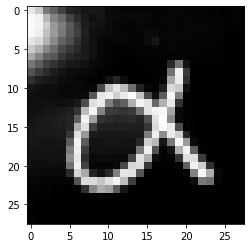


index:>>>> 1
ground truth: Alphabet.BETA


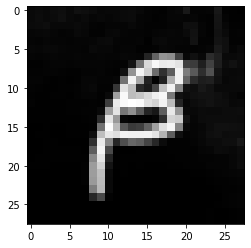


index:>>>> 2
ground truth: Alphabet.GAMMA


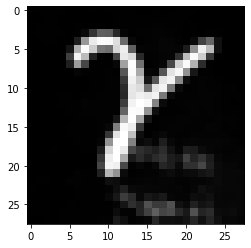


index:>>>> 3
ground truth: Alphabet.GAMMA


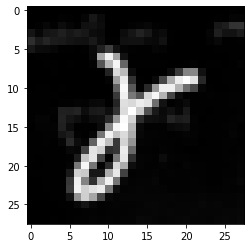

In [17]:
# - create the Dataset from our images folder 
dataset_name = "own_greek"
own_csv_dataloader = create_Dataset_CSV(dataset_name)
own_data_from_csv, own_target = next(iter(own_csv_dataloader))

In [18]:
# 1. get 1 sample of each letter
sample_alpha = own_data_from_csv[0]
sample_beta = own_data_from_csv[1]
sample_gamma = own_data_from_csv[2]
sample_gamma_a = own_data_from_csv[3]

# 2. compute ssd of the 3 samples above to each of the 27 other samples
compute_ssd_all_data(sample_alpha, data_from_csv, "alpha")
compute_ssd_all_data(sample_beta, data_from_csv, "beta")
compute_ssd_all_data(sample_gamma, data_from_csv, "gamma")
compute_ssd_all_data(sample_gamma_a, data_from_csv, "gamma_a")

print(sample_alpha.shape)


>>>>>>>>> SSD for alpha sample:
> alpha:
488.6144387071153
452.5317175480224
419.9771092829113
503.5115812827304
474.5567142927742
430.5076766375094
453.40860701529584
517.0293086067668
437.6137104071084
> beta:
656.4267952289159
543.3541413728237
487.1615756227581
525.8326025680861
440.961821859994
474.4093955192957
519.4299562295071
501.54597464801617
555.1180846449887
> gamma:
644.1159391797758
553.3719655881915
573.6883137662417
556.8853838825553
586.0812429214294
550.8830731472152
549.0186963268237
563.8124832655395
523.0090492147053

>>>>>>>>> SSD for beta sample:
> alpha:
387.6807342046811
373.07492904744515
354.0737063116361
350.3320668938716
331.02491967498884
341.31950477925307
387.897349361453
291.7616339514955
267.1405571380961
> beta:
601.9989751560561
371.9329899720699
286.28293018176726
329.58195592257687
406.9875618303201
266.21459705084106
352.3574990333725
386.75743334032825
417.76050889386283
> gamma:
401.8799197742636
345.21889066607116
365.3419338869198
321.715162